In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import svm

from sklearn.svm import LinearSVC, SVC
from sklearn.feature_selection import RFECV, mutual_info_classif

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score, 

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [2]:
# Using seaborn's style
nice_fonts = {
        # Use LaTeX to write all text
        "text.usetex": False,
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 10,
        "font.size": 10,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
}

plt.rcParams.update(nice_fonts)

def set_size(width, fraction=1):
    """ Set aesthetic figure dimensions to avoid scaling in latex.

    Parameters
    ----------
    width: float
            Width in pts
    fraction: float
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

width = 418.25368

## Load data

In [3]:
def get_data():
    
    try:
        columns = np.load("data_columns.npy")
        X = np.load("data_valence_physio_with_pupil_for_svm_only_valid_session.npy")
        Y = np.load("data_valence_label_with_pupil_for_svm_only_valid_session.npy")
        return pd.DataFrame(X, columns=columns), pd.DataFrame(Y)
    except:
        print "No stored files found.. load from files first"

(82400, 25)
(82400, 1)


0    82400
dtype: int64

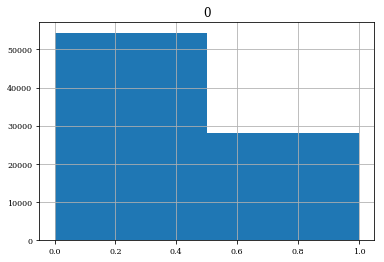

In [4]:
X, Y = get_data()
#X = X.drop(["SKT_mean_abs_diff", "SKT_std"], axis=1)
print X.shape
print Y.shape

# binarize the problem
Y[Y<=4] = 0
Y[Y>=5] = 1
Y.hist(bins=2)
Y.count()

## LinearSVC

### Search for optimal C parameter

In [5]:
def create_classifier(c=1):
    lsvc = LinearSVC(C=c, tol=1e-4, dual=False, fit_intercept=False, class_weight='balanced', random_state=seed, verbose=True)
    # evaluate using 5-fold cross validation
    #stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    stratified_cv = StratifiedShuffleSplit(n_splits=5, test_size=.2, random_state=seed)
    return lsvc, stratified_cv

In [6]:
result = []

for i in range(5,-5,-1):
    c = 1*10**i
    lsvc, stratified_cv = create_classifier(c=c)
    results = cross_val_score(lsvc, X, Y, cv=stratified_cv, scoring='balanced_accuracy', verbose=0)
    result.append({ "c": c, "score" : results.mean()*100, "std" : results.std()*100})

/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

In [7]:
for r in sorted(result, key=lambda x: x["score"]):
    print "c: {:.0e} --> score: {}".format(r["c"], r["score"])
    
max_score = max(result, key=lambda x: x["score"])

print
print "optimal value: {:.0e}".format(max_score["c"])
print("Accuracy: %.2f%% (%.2f%%)" % (max_score["score"], max_score["std"]))

c: 1e-04 --> score: 57.7792804622
c: 1e-03 --> score: 59.3477941176
c: 1e-02 --> score: 59.6007090336
c: 1e-01 --> score: 60.5941439076
c: 1e+03 --> score: 60.6209296218
c: 1e+05 --> score: 60.6218487395
c: 1e+04 --> score: 60.6236344538
c: 1e+02 --> score: 60.6245535714
c: 1e+01 --> score: 60.627914916
c: 1e+00 --> score: 60.7042804622

optimal value: 1e+00
Accuracy: 60.70% (0.34%)


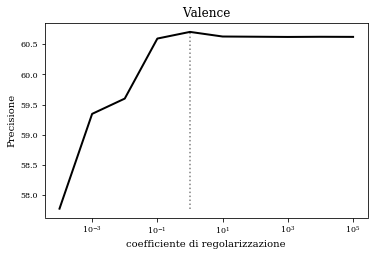

In [59]:
results = { r["c"] : r for r in result }
c_values = list(sorted(results.keys()))
scores = [ results[c]["score"] for c in c_values ]
fig = plt.figure(figsize=set_size(width=width))
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(c_values, scores, color='k', lw=2)
ax.vlines([1e+00], min(scores), max(scores), colors='gray', linestyles="dotted")
ax.set_xscale('log')
ax.set_title("Valence")
ax.set_ylabel("Precisione")
ax.set_xlabel("coefficiente di regolarizzazione")
plt.show()
fig.savefig("reg_coef_val.pdf", format="pdf", bbox_inches='tight')

Create classifier with optimal parameter

## KBest Feature selection + SVC

In [22]:
# Such a large set of features can cause overfitting and also slow computing
# Use feature selection to select the most important features
import sklearn.feature_selection
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, auc, roc_curve

In [23]:
scores_by_kbest = []

for k in range(1,X.shape[1]+1):

    lsvc, stratified_cv = create_classifier() 
    kbest_selector = sklearn.feature_selection.SelectKBest(k=k)
    kbest_selector.fit(X, Y)
    
    scores_train = []
    scores_test = []
    
    for train_index, test_index in stratified_cv.split(X, Y):
        
        x_train, y_train = kbest_selector.transform(X)[train_index], Y.iloc[train_index]
        x_test, y_test = kbest_selector.transform(X)[test_index], Y.iloc[test_index]
        
        lsvc.fit(x_train, y_train)
        
        y_train_pred = lsvc.predict(x_train)
        score = balanced_accuracy_score(y_train, y_train_pred)
        scores_train.append(score)
        
        y_test_pred = lsvc.predict(x_test)
        score = balanced_accuracy_score(y_test, y_test_pred)
        scores_test.append(score)
        
        fpr, tpr, threshold = roc_curve(y_test, y_test_pred)
        roc_auc = auc(fpr, tpr)
        
        #results = cross_val_score(lsvc, kbest_selector.transform(X), Y, scoring='balanced_accuracy', cv=stratified_cv, verbose=0)
    
    ks = {
        "feature"         : X.columns[kbest_selector.get_support()],
        "feature_pvalue"  : kbest_selector.pvalues_,
        "feature_coeff"   : lsvc.coef_,
        "score_train"     : np.array(scores_train).mean(),
        "std_train"       : np.array(scores_train).std(),
        "score_test"      : np.array(scores_test).mean(),
        "std_test"        : np.array(scores_test).std(),
        "fpr"             : fpr,
        "tpr"             : tpr,
        "roc_auc"         : roc_auc
    }
    
    scores_by_kbest.append(ks)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear

In [24]:
for r in sorted(scores_by_kbest, key=lambda x: x["roc_auc"]):
    nfeature, score_train, score_test = len(r["feature"]), r["score_train"], r["score_test"]
    roc_auc = r["roc_auc"]
    print "n: {} --> score_train: {:.2f} --> score_test: {:.2f} --> roc_auc: {:.2f}".format(nfeature, score_train, score_test, roc_auc)

n: 1 --> score_train: 0.50 --> score_test: 0.50 --> roc_auc: 0.50
n: 2 --> score_train: 0.56 --> score_test: 0.55 --> roc_auc: 0.55
n: 7 --> score_train: 0.57 --> score_test: 0.57 --> roc_auc: 0.56
n: 4 --> score_train: 0.57 --> score_test: 0.57 --> roc_auc: 0.56
n: 5 --> score_train: 0.57 --> score_test: 0.57 --> roc_auc: 0.57
n: 6 --> score_train: 0.57 --> score_test: 0.57 --> roc_auc: 0.57
n: 8 --> score_train: 0.57 --> score_test: 0.57 --> roc_auc: 0.57
n: 3 --> score_train: 0.57 --> score_test: 0.57 --> roc_auc: 0.57
n: 9 --> score_train: 0.58 --> score_test: 0.58 --> roc_auc: 0.57
n: 10 --> score_train: 0.58 --> score_test: 0.58 --> roc_auc: 0.57
n: 12 --> score_train: 0.59 --> score_test: 0.59 --> roc_auc: 0.58
n: 11 --> score_train: 0.59 --> score_test: 0.59 --> roc_auc: 0.59
n: 13 --> score_train: 0.59 --> score_test: 0.59 --> roc_auc: 0.59
n: 14 --> score_train: 0.59 --> score_test: 0.59 --> roc_auc: 0.59
n: 15 --> score_train: 0.59 --> score_test: 0.59 --> roc_auc: 0.59
n: 1

In [25]:
max_score = max(scores_by_kbest, key=lambda x: x["score_test"])
print("Optimal number of features : %d" % len(max_score["feature"]))
print
print("Accuracy: %.2f%% (%.2f%%)" % (max_score["score_test"]*100, max_score["std_test"]*100))

Optimal number of features : 23

Accuracy: 60.98% (0.33%)


In [26]:
from pprint import pprint
features = max_score['feature']
coef_norm = np.abs(max_score['feature_coeff'])[0]
#coef_norm = (coef_norm - coef_norm.min()) / (coef_norm.max() - coef_norm.min())
coef_norm = coef_norm / coef_norm.sum()
feature_rank = zip(max_score["feature"], coef_norm)
print sorted(feature_rank, key=lambda x: x[1])
feature_rank = dict(feature_rank)
pprint(feature_rank)

[('ECG_min', 0.0018591598781892674), ('ECG_max', 0.001888109648987091), ('ECG_mean_diff', 0.002781320605918507), ('ECG_mean_abs_diff', 0.005231125053370179), ('Pupil', 0.005767991044728216), ('Resp_mean_abs_diff', 0.006296669544639612), ('ECG_mean', 0.00662804554999091), ('ECG_std', 0.0081674871185979), ('SKT_mean_diff', 0.009693591729136704), ('Resp_std', 0.01175162024068132), ('EDA_mean_diff', 0.011888787093495388), ('EDA_max', 0.016387547992571822), ('EDA_min', 0.024962515338228963), ('Resp_mean', 0.025309698048227646), ('EDA_mean', 0.027063790450369923), ('Resp_min', 0.038120661037035986), ('SKT_std', 0.06872535872884428), ('SKT_mean_abs_diff', 0.08268450584592513), ('EDA_std', 0.09222202087231755), ('EDA_mean_abs_diff', 0.09415495854705104), ('SKT_min', 0.11280498263646793), ('SKT_max', 0.11762136629734976), ('SKT_mean', 0.22798868669787506)]
{'ECG_max': 0.001888109648987091,
 'ECG_mean': 0.00662804554999091,
 'ECG_mean_abs_diff': 0.005231125053370179,
 'ECG_mean_diff': 0.00278132

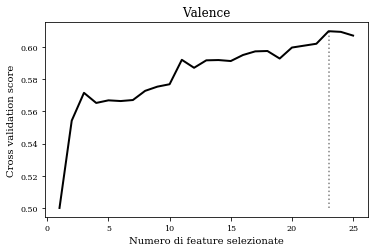

In [58]:
nfeature = [ len(s["feature"]) for s in scores_by_kbest ]
scores = [ s["score_test"] for s in scores_by_kbest ]
plt.figure(figsize=set_size(width=width))
plt.title('Valence')
plt.xlabel("Numero di feature selezionate")
plt.ylabel("Cross validation score")
plt.plot(nfeature, scores, color='k', lw=2)
plt.gca().vlines([len(max_score["feature"])], min(scores), max(scores), colors='gray', linestyles="dotted")
plt.show()
fig.savefig("kbest_val.pdf", format="pdf", bbox_inches='tight')

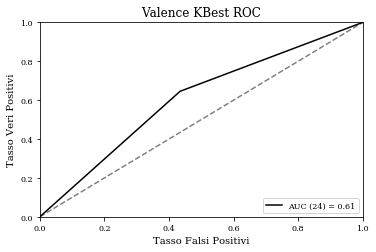

In [57]:
from itertools import cycle
lines = ["-","--","-.",":"]
linecycler = cycle(lines)

fig = plt.figure(figsize=set_size(width=width))
ax = fig.add_subplot(1,1,1)
plt.title('Valence KBest ROC')
plt.plot([0, 1], [0, 1],'--', c='gray')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Tasso Veri Positivi')
plt.xlabel('Tasso Falsi Positivi')
for r in scores_by_kbest[23:24]:
    n = len(r["feature"])
    fpr, tpr, roc_auc = r["fpr"], r["tpr"], r["roc_auc"]
    linestyle = next(linecycler)
    ax.plot(fpr, tpr, 'k-', label = 'AUC (%d) = %0.2f' % (n, roc_auc))

plt.legend(loc = 'lower right')      
plt.show()
fig.savefig("kbest_roc_val.pdf", format="pdf", bbox_inches='tight')

## Recursive feature selection

In [29]:
lsvc, stratified_cv = create_classifier()
rfecv = RFECV(estimator=lsvc, step=1, cv=stratified_cv, scoring='balanced_accuracy', n_jobs=-1)

In [30]:
rfecv.fit(X, Y)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

RFECV(cv=StratifiedShuffleSplit(n_splits=5, random_state=7, test_size=0.2,
            train_size=None),
   estimator=LinearSVC(C=1, class_weight='balanced', dual=False, fit_intercept=False,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=7, tol=0.0001,
     verbose=True),
   min_features_to_select=1, n_jobs=-1, scoring='balanced_accuracy',
   step=1, verbose=0)

In [31]:
print rfecv.n_features_
print rfecv.get_support()
print X.columns[rfecv.get_support()]
print rfecv.ranking_
print rfecv.grid_scores_

20
[ True  True False False False  True  True  True  True  True  True  True
  True  True  True False False  True  True  True  True  True  True  True
  True]
Index([u'ECG_mean', u'ECG_std', u'ECG_mean_abs_diff', u'EDA_mean', u'EDA_std',
       u'EDA_min', u'EDA_max', u'EDA_mean_diff', u'EDA_mean_abs_diff',
       u'Resp_mean', u'Resp_std', u'Resp_min', u'Resp_mean_abs_diff',
       u'SKT_mean', u'SKT_std', u'SKT_min', u'SKT_max', u'SKT_mean_diff',
       u'SKT_mean_abs_diff', u'Pupil'],
      dtype='object')
[1 1 5 4 2 1 1 1 1 1 1 1 1 1 1 3 6 1 1 1 1 1 1 1 1]
[0.5        0.56345247 0.55235767 0.54610452 0.54544853 0.57028834
 0.56957931 0.5864333  0.59116912 0.58724449 0.58912631 0.5980969
 0.5978645  0.59829228 0.60426471 0.60348871 0.60224947 0.60534191
 0.60644091 0.60940389 0.60846717 0.60708613 0.60705593 0.60679438
 0.6070428 ]


In [32]:
print("Optimal number of features : %d" % rfecv.n_features_)
print X.columns[rfecv.get_support()]

print
print("Accuracy: %.2f%% (%.2f%%)" % (rfecv.grid_scores_[rfecv.n_features_-1]*100, 0))

Optimal number of features : 20
Index([u'ECG_mean', u'ECG_std', u'ECG_mean_abs_diff', u'EDA_mean', u'EDA_std',
       u'EDA_min', u'EDA_max', u'EDA_mean_diff', u'EDA_mean_abs_diff',
       u'Resp_mean', u'Resp_std', u'Resp_min', u'Resp_mean_abs_diff',
       u'SKT_mean', u'SKT_std', u'SKT_min', u'SKT_max', u'SKT_mean_diff',
       u'SKT_mean_abs_diff', u'Pupil'],
      dtype='object')

Accuracy: 60.94% (0.00%)


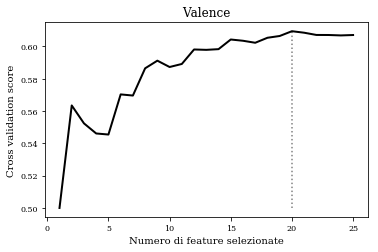

In [55]:
# Plot number of features VS. cross-validation scores
nfeature = range(1, X.shape[1]+1)
plt.figure(figsize=set_size(width=width))
plt.title("Valence")
plt.xlabel("Numero di feature selezionate")
plt.ylabel("Cross validation score")
plt.plot(nfeature, rfecv.grid_scores_, color='K', lw=2)
plt.gca().vlines([rfecv.n_features_], min(rfecv.grid_scores_), max(rfecv.grid_scores_), colors='gray', linestyles="dotted")
plt.show()
fig.savefig("rfecv_val.pdf", format="pdf", bbox_inches='tight')

In [34]:
# GENERATE ROC FOR RFECV
lsvc, stratified_cv = create_classifier(c=1e2) 
scores_train = []
scores_test = []
for train_index, test_index in stratified_cv.split(X, Y):

    x_train, y_train = rfecv.transform(X)[train_index], Y.iloc[train_index]
    x_test, y_test = rfecv.transform(X)[test_index], Y.iloc[test_index]

    lsvc.fit(x_train, y_train)

    y_train_pred = lsvc.predict(x_train)
    score = balanced_accuracy_score(y_train, y_train_pred)
    scores_train.append(score)

    y_test_pred = lsvc.predict(x_test)
    score = balanced_accuracy_score(y_test, y_test_pred)
    scores_test.append(score)

    fpr, tpr, threshold = roc_curve(y_test, y_test_pred)
    roc_auc = auc(fpr, tpr)
    
    r = {
        "feature"         : X.columns[kbest_selector.get_support()],
        "feature_pvalue"  : kbest_selector.pvalues_,
        "feature_coeff"   : lsvc.coef_,
        "score_train"     : np.array(scores_train).mean(),
        "std_train"       : np.array(scores_train).std(),
        "score_test"      : np.array(scores_test).mean(),
        "std_test"        : np.array(scores_test).std(),
        "fpr"             : fpr,
        "tpr"             : tpr,
        "roc_auc"         : roc_auc
    }

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

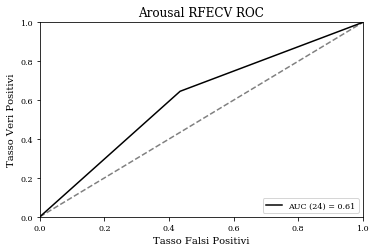

In [54]:
## PLOT ROC CURVE FOR KBEST AND RFECV

fig = plt.figure(figsize=set_size(width=width))
ax = fig.add_subplot(1,1,1)
plt.title('Arousal RFECV ROC')
plt.plot([0, 1], [0, 1],'--', c='gray')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Tasso Veri Positivi')
plt.xlabel('Tasso Falsi Positivi')

n = len(r["feature"])
fpr, tpr, roc_auc = r["fpr"], r["tpr"], r["roc_auc"]
ax.plot(fpr, tpr, 'k-', label = 'AUC (%d) = %0.2f' % (n, roc_auc))

plt.legend(loc = 'lower right')      
plt.show()
fig.savefig("rfecv_roc_val.pdf", format="pdf", bbox_inches='tight')